In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/hackathon_swf/module/')

In [3]:
%load_ext autoreload
%autoreload 2

In [36]:
import cv2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import tensorflow as tf

from model import EventDetector
from eval import ToTensor, Normalize

## Получение кадров начала фаз свинга

In [6]:
class SampleVideo(Dataset):
    def __init__(self, path, input_size=160, transform=None):
        self.path = path
        self.input_size = input_size
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        cap = cv2.VideoCapture(self.path)
        frame_size = [cap.get(cv2.CAP_PROP_FRAME_HEIGHT), cap.get(cv2.CAP_PROP_FRAME_WIDTH)]
        ratio = self.input_size / max(frame_size)
        new_size = tuple([int(x * ratio) for x in frame_size])
        delta_w = self.input_size - new_size[1]
        delta_h = self.input_size - new_size[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        # preprocess and return frames
        images = []
        for pos in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            _, img = cap.read()
            resized = cv2.resize(img, (new_size[1], new_size[0]))
            b_img = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                       value=[0.406 * 255, 0.456 * 255, 0.485 * 255])  # ImageNet means (BGR)
            b_img_rgb = cv2.cvtColor(b_img, cv2.COLOR_BGR2RGB)

            images.append(b_img_rgb)
        cap.release()
        labels = np.zeros(len(images)) # only for compatibility with transforms
        sample = {'images': np.asarray(images), 'labels': np.asarray(labels)}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [7]:
def process_video(model, dl, seq_length):
    for sample in dl:
        images = sample['images']
        # full samples do not fit into GPU memory so evaluate sample in 'seq_length' batches
        batch = 0
        while batch * seq_length < images.shape[1]:
            if (batch + 1) * seq_length > images.shape[1]:
                image_batch = images[:, batch * seq_length:, :, :, :]
            else:
                image_batch = images[:, batch * seq_length:(batch + 1) * seq_length, :, :, :]
            logits = model(image_batch.cuda())
            if batch == 0:
                probs = F.softmax(logits.data, dim=1).cpu().numpy()
            else:
                probs = np.append(probs, F.softmax(logits.data, dim=1).cpu().numpy(), 0)
            batch += 1

    events = np.argmax(probs, axis=0)[:-1]
    print('Predicted event frames: {}'.format(events))

    confidence = []
    for i, e in enumerate(events):
        confidence.append(probs[e, i])
    print('Condifence: {}'.format([np.round(c, 3) for c in confidence]))

    return events, confidence


In [ ]:
model = EventDetector(pretrain=True,
                      width_mult=1.,
                      lstm_layers=1,
                      lstm_hidden=256,
                      bidirectional=True,
                      dropout=False)

save_dict = torch.load('/content/drive/MyDrive/hackathon_swf/weights/swingnet_1800.pth.tar')
model.load_state_dict(save_dict['model_state_dict'])
model.cuda()
model.eval()

In [8]:
ds = SampleVideo('/content/drive/MyDrive/hackathon_swf/videos/test_video.mp4', transform=transforms.Compose([ToTensor(),
                                Normalize([0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]))

dl = DataLoader(ds, batch_size=1, shuffle=False, drop_last=False)


In [9]:
seq_length = 64
events, confidence = process_video(model, dl, seq_length)

Predicted event frames: [ 74  86  98 114 132 143 151 236]
Condifence: [0.095, 0.593, 0.795, 0.718, 0.865, 0.975, 0.765, 0.159]


## Нахождение ключевых точек на предсказанных кадрах

In [22]:
def load_tflite_model():
    interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/hackathon_swf/lite-model_movenet_singlepose_lightning_tflite_float16_4.tflite")
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    return interpreter, input_details, output_details


In [23]:
def get_kps(interpreter, input_details, output_details, img):
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

In [24]:
def preprocess_img_for_kps_model(img):
    img_cp = cv2.resize(img, (192, 192))
    img_cp = img_cp[None, ...].astype(np.uint8)
    return img_cp

In [77]:
def plot_skeleton_kpts(img_orig, kpts, steps, orig_shape=None):
    im = img_orig.copy()
    #Plot the skeleton and keypointsfor coco datatset
    palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                        [230, 230, 0], [255, 153, 255], [153, 204, 255],
                        [255, 102, 255], [255, 51, 255], [102, 178, 255],
                        [51, 153, 255], [255, 153, 153], [255, 102, 102],
                        [255, 51, 51], [153, 255, 153], [102, 255, 102],
                        [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                        [255, 255, 255]])

    skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
                [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
                [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

    pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
    pose_kpt_color = palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]
    radius = 5
    conf_level=0.2
    num_kpts = len(kpts) // steps

    for kid in range(num_kpts):
        r, g, b = pose_kpt_color[kid]
        x_coord, y_coord = kpts[kid, 1], kpts[kid, 0]
        conf = kpts[kid, 2]
        if conf < conf_level:
            continue
        cv2.circle(im, (int(x_coord), int(y_coord)), radius, (int(r), int(g), int(b)), -1)

    for sk_id, sk in enumerate(skeleton):
        r, g, b = pose_limb_color[sk_id]
        pos1 = (int(kpts[(sk[0]-1), 1]), int(kpts[(sk[0]-1), 0]))
        pos2 = (int(kpts[(sk[1]-1), 1]), int(kpts[(sk[1]-1), 0]))
        conf1 = kpts[(sk[0]-1), 2]
        conf2 = kpts[(sk[1]-1), 2]
        if conf1<conf_level or conf2<conf_level:
            continue

        if pos1[0]%640 == 0 or pos1[1]%640==0 or pos1[0]<0 or pos1[1]<0:
            continue
        if pos2[0] % 640 == 0 or pos2[1] % 640 == 0 or pos2[0]<0 or pos2[1]<0:
            continue
        cv2.line(im, pos1, pos2, (int(r), int(g), int(b)), thickness=2)
    return im

In [71]:
interpreter, input_details, output_details = load_tflite_model()

In [83]:
video_path = "/content/drive/MyDrive/hackathon_swf/videos/test_video.mp4"
cap = cv2.VideoCapture(video_path)

kps_array = []
images_array = []
event_num = 0

for pos in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    _, img = cap.read()

    if pos == events[event_num]:
        img_prp = preprocess_img_for_kps_model(img)
        images_array += [img]
        kps = get_kps(interpreter, input_details, output_details, img_prp)[0][0]
        kps_array += [kps]
        event_num += 1
        if event_num == 8: break

cap.release()
kps_array = np.asarray(kps_array)
images_array = np.asarray(images_array)

print(kps_array.shape, images_array.shape)

(8, 17, 3) (8, 492, 354, 3)


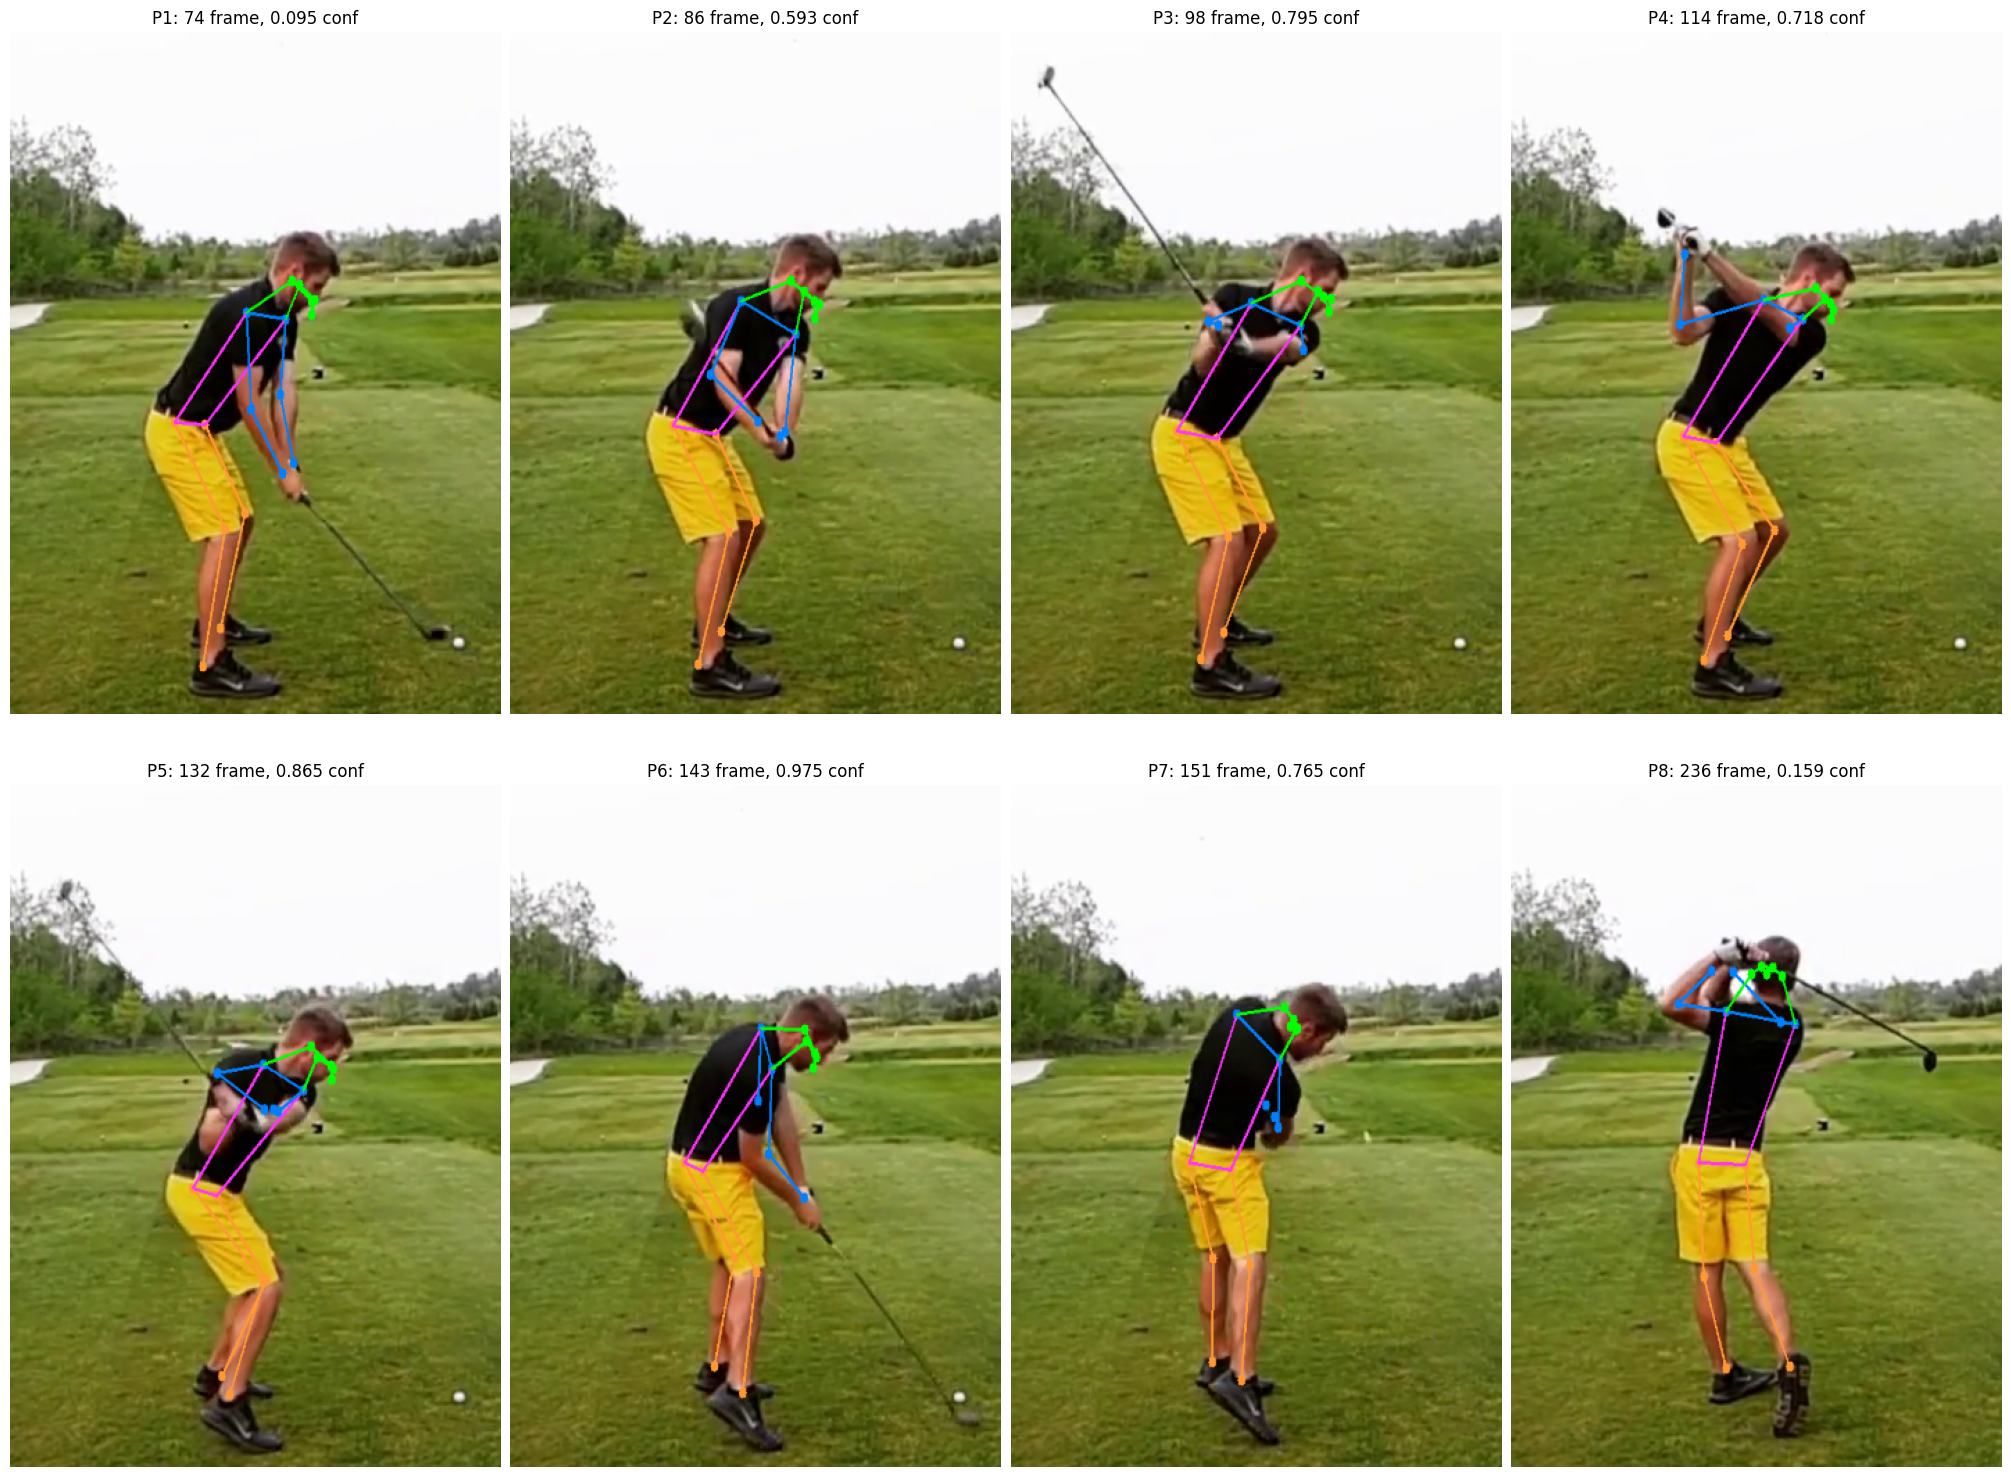

In [90]:
figure, axes = plt.subplots(2, 4, figsize=(20, 15), constrained_layout=True)

height, width = images_array.shape[1:3]
kps_array_cp = kps_array.copy()
kps_array_cp[:, :, 0] *= 640
kps_array_cp[:, :, 1] *= 640


for i in range(8):
    img_plot = cv2.resize(images_array[i], (640, 640))
    img_kps = plot_skeleton_kpts(img_plot, kps_array_cp[i], steps=1)[..., ::-1]
    axes[i//4, i%4].imshow(cv2.resize(img_kps, (width, height)))
    axes[i//4, i%4].set_title(f"P{i+1}: {events[i]} frame, {confidence[i]:.3f} conf")
    axes[i//4, i%4].axis("off")
